In [116]:
import pandas as pd
import numpy as np
import kaggle

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white')
np.random.seed(0)

In [ ]:
# # authenticate kaggle credentials
# kaggle.api.authenticate()

# # download dataset
# kaggle.api.dataset_download_files('ahmedmohamed2003/cafe-sales-dirty-data-for-cleaning-training', path='data', unzip=True)

In [ ]:
# load data
df = pd.read_csv('data/dirty_cafe_sales.csv')
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


# EDA

In [ ]:
# check the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [ ]:
# check the descriptives
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [ ]:
# check for missing values
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [ ]:
# check for duplicates
df.duplicated().sum()

np.int64(0)

# Preprocessing

### Handling missing values

In [123]:
# make a copy of the dataframe
df1 = df.copy()

In [124]:
# replace "ERROR" and "UNKNOWN" with np.nan
df1 = df1.replace(["ERROR", "UNKNOWN"], np.nan, regex=True)


In [125]:
# convert to numeric
df1[['Price Per Unit', 'Quantity', 'Total Spent']] = df1[['Price Per Unit', 'Quantity', 'Total Spent']].apply(pd.to_numeric, errors='coerce')

# convert to category
df1[['Item', 'Location', 'Payment Method']] = df1[['Item', 'Location', 'Payment Method']].astype('category')

# convert to datetime
df1['Transaction Date'] = pd.to_datetime(df1['Transaction Date'], errors='coerce')

In [126]:
# Check what percentage of the data is missing
total_null = df1.isnull().sum().sum()
total_cells = np.prod(df1.shape)
percentage_null = (total_null / total_cells) * 100
percentage_null

np.float64(12.6025)

In [127]:
# create a dictionary with the known menu prices
menu = {
    "Coffee": 2,
    "Tea": 1.5,
    "Sandwich": 4,
    "Salad": 5,
    "Cake": 3,
    "Cookie": 1,
    "Smoothie": 4,
    "Juice": 3
}

# fill the missing Price Per Unit values where Item is not null
df1['Price Per Unit'] = df1['Price Per Unit'].fillna(df1['Item'].map(menu))

In [128]:
# create a function to fill missing values in the numeric columns
def fill_NaN(df1):
    # fill missing values in Total Spent by Price Per Unit * Quantity
    condition = df1['Price Per Unit'].notnull() & df1['Quantity'].notnull()
    df1.loc[condition, 'Total Spent'] = df1.loc[condition, 'Price Per Unit'] * df1.loc[condition, 'Quantity']

    #fill missing values in Quantity by Total Spent / Price Per Unit
    condition = df1['Total Spent'].notnull() & df1['Quantity'].notnull()
    df1.loc[condition, 'Price Per Unit'] = df1.loc[condition, 'Total Spent'] / df1.loc[condition, 'Quantity']

    #fill missing values in Price Per Unit by Total Spent / Quantity
    condition = df1['Total Spent'].notnull() & df1['Price Per Unit'].notnull()
    df1.loc[condition, 'Quantity'] = df1.loc[condition, 'Total Spent'] / df1.loc[condition, 'Price Per Unit']

    return df1

df1 = fill_NaN(df1)

In [129]:
# create an items dictionary that maps the menu prices in reverse
items = {
    2: "Coffee",
    1.5: "Tea",
    4 : "Sandwich",
    5 : "Salad",
    3 : "Cake",
    1 : "Cookie",
    4 : "Smoothie",
    3 : "Juice"
}

# fill the missing Item where Price Per Unit is not null
df1['Item'] = df1['Item'].fillna(df1['Price Per Unit'].map(items))

In [130]:
# fill the remaining missing values in Item by the mode
df1['Item'] = df1['Item'].fillna(df1['Item'].mode()[0])

# fill the remaining missing values Price Per Unit with the known Item prices
df1['Price Per Unit'] = df1['Price Per Unit'].fillna(df1['Item'].map(menu))

In [131]:
# fill the re missing values in Quantity by the mean quantity of each Item
df1['Quantity'] = df1['Quantity'].fillna(df1.groupby('Item')['Quantity'].transform('mean'))

/var/folders/zm/8y1z6y9d5bb7wb7r7cp865540000gn/T/ipykernel_34245/3829078265.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1['Quantity'] = df1['Quantity'].fillna(df1.groupby('Item')['Quantity'].transform('mean'))


In [132]:
# run the function again to fill the missing values in Total Spent
df1 = fill_NaN(df1)

In [133]:
df1['Payment Method'].value_counts()

Payment Method
Digital Wallet    2291
Credit Card       2273
Cash              2258
Name: count, dtype: int64

In [134]:
# keep the distribution of 'Payment Method' since its relatively balanced

# calculate the distribution of 'Payment Method'
payment_proportions = df1['Payment Method'].value_counts(normalize=True)

# assign missing values based on the distribution
df1.loc[df1['Payment Method'].isna(), 'Payment Method'] = np.random.choice(
    payment_proportions.index, 
    size=df1['Payment Method'].isna().sum(), 
    p=payment_proportions.values
)

In [135]:
# like in the previous step, we keep the distribution of 'Location' since it's also relatively balanced

# calculate the distribution of 'Location'
location_proportions = df1['Location'].value_counts(normalize=True)

# assign missing values based on the distribution
df1.loc[df1['Location'].isna(), 'Location'] = np.random.choice(
    location_proportions.index, 
    size=df1['Location'].isna().sum(), 
    p=location_proportions.values
)

In [136]:
# fill the missing values in 'Transaction Date' with the following valid value
df1['Transaction Date'] = df1['Transaction Date'].ffill()

In [137]:
df1.isnull().sum()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

The dataset now contains no missing values.

### Outliers

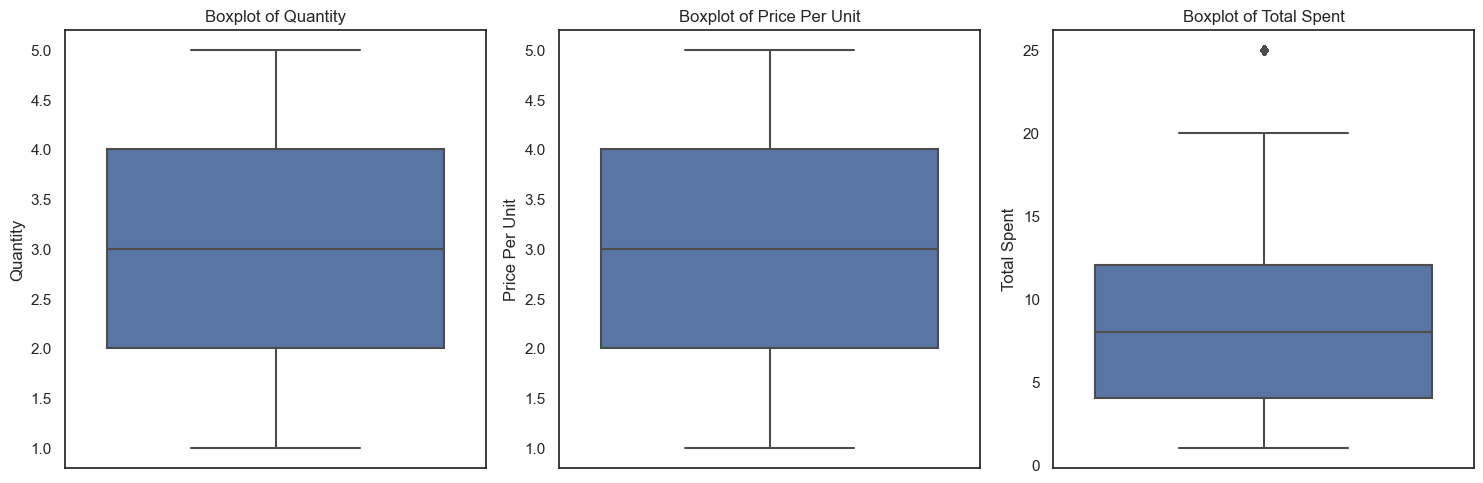

In [138]:
# boxplots of numeric columns

num_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

plt.figure(figsize=(15, 5))
for i, column in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df1[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

In [144]:
# calculate the quartiles for Total Spent
Q1 = df1['Total Spent'].quantile(0.25)
Q3 = df1['Total Spent'].quantile(0.75)
IQR = Q3 - Q1

# define the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# calculate the number of outliers
outliers = (df1['Total Spent'] < (lower_bound)) | (df1['Total Spent'] > (upper_bound))
num_outliers = outliers.sum()
print(num_outliers)

268


Although they may be considered outliers based on the IQR method, these are genuine entries that correspond to the product of Price Per Unit and Quantity.